# Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Supervised Model

In [2]:
df = pd.read_csv("final.csv")

In [3]:
num_cols = ['coherence','knowledge','teaching','management','responsiveness','behavior']

# میانگین همه 6 ستون numeric برای هر استاد
prof_agg_scores = df.groupby('professor')[num_cols].mean()  # هر ستون میانگین خودش
prof_agg_scores['overall_score'] = prof_agg_scores.mean(axis=1)  # میانگین 6 ستون → یک عدد یکتا

# میانگین sentiment
prof_agg_sent = df.groupby('professor')['sentiment'].mean()

# combine into final dataframe
prof_agg = pd.DataFrame({
    'professor': prof_agg_scores.index,
    'overall_score': prof_agg_scores['overall_score'].values,
    'mean_sentiment': prof_agg_sent.values
}).reset_index(drop=True)


In [4]:
# add mean overall score across 6 columns
prof_agg['overall_score'] = df.groupby('professor')[num_cols].mean().mean(axis=1).values

In [5]:
# target: most frequent grading_label per professor
label_map = {'آسان':0, 'منصفانه':1, 'سخت گیر':2, 'نامشخص':3}
prof_labels = df.groupby('professor')['grading_status'].agg(lambda x: x.mode()[0])
prof_agg['grading_status'] = prof_labels.values
prof_agg['grading_numeric'] = prof_agg['grading_status'].map(label_map)

In [6]:
features = ['overall_score','mean_sentiment']
X = prof_agg[features].copy()
y = prof_agg['grading_numeric'].astype(int)

In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
# Logistic Regression (multinomial)
pipe_lr = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42)
)

# Random Forest
pipe_rf = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=42)
)

In [9]:
# Fit models
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('simpleimputer', ...), ('randomforestclassifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness desp

In [10]:
def eval_and_plot(pipe, X_test, y_test, name):
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    bal = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"\n--- {name} ---")
    print("Accuracy:      ", round(acc,4))
    print("Balanced Acc:  ", round(bal,4))
    print("Macro F1:      ", round(f1,4))
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=list(label_map.keys())))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_map.keys()), yticklabels=list(label_map.keys()))
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    return y_pred


--- Logistic Regression (per professor) ---
Accuracy:       0.4773
Balanced Acc:   0.4461
Macro F1:       0.3883

Classification report:
              precision    recall  f1-score   support

        آسان       0.52      0.76      0.62        45
     منصفانه       0.45      0.20      0.27        46
     سخت گیر       0.66      0.50      0.57        38
      نامشخص       0.06      0.33      0.10         3

    accuracy                           0.48       132
   macro avg       0.42      0.45      0.39       132
weighted avg       0.53      0.48      0.47       132



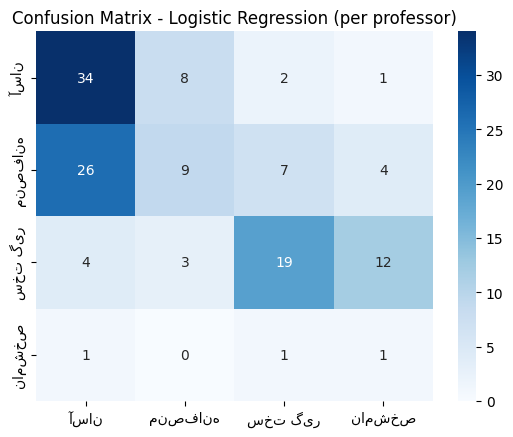


--- Random Forest (per professor) ---
Accuracy:       0.447
Balanced Acc:   0.4285
Macro F1:       0.3947

Classification report:
              precision    recall  f1-score   support

        آسان       0.46      0.47      0.46        45
     منصفانه       0.34      0.28      0.31        46
     سخت گیر       0.59      0.63      0.61        38
      نامشخص       0.14      0.33      0.20         3

    accuracy                           0.45       132
   macro avg       0.38      0.43      0.39       132
weighted avg       0.45      0.45      0.44       132



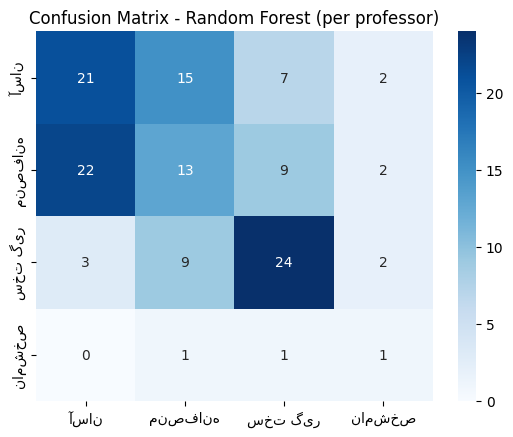

In [11]:
# Evaluate
y_pred_lr = eval_and_plot(pipe_lr, X_test, y_test, "Logistic Regression (per professor)")
y_pred_rf = eval_and_plot(pipe_rf, X_test, y_test, "Random Forest (per professor)")

# Unsupervised Model

In [12]:
num_cols = ['coherence','knowledge','teaching','management','responsiveness','behavior']

# میانگین همه 6 ستون numeric برای هر استاد
prof_agg_scores = df.groupby('professor')[num_cols].mean()  # هر ستون میانگین خودش
prof_agg_scores['overall_score'] = prof_agg_scores.mean(axis=1)  # میانگین 6 ستون → یک عدد یکتا

# میانگین sentiment
prof_agg_sent = df.groupby('professor')['sentiment'].mean()

# combine into final dataframe
prof_agg = pd.DataFrame({
    'professor': prof_agg_scores.index,
    'overall_score': prof_agg_scores['overall_score'].values,
    'mean_sentiment': prof_agg_sent.values
}).reset_index(drop=True)


In [13]:
# encode grading_label as numeric for clustering
label_map = {'آسان':0, 'منصفانه':1, 'سخت گیر':2, 'نامشخص':3}
prof_labels = df.groupby('professor')['grading_status'].agg(lambda x: x.mode()[0])  # most frequent
prof_agg['grading_numeric'] = prof_labels.map(label_map).values

In [14]:
# final features for clustering
features = ['overall_score','mean_sentiment','grading_numeric']
X = prof_agg[features].values

In [15]:
# standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
prof_agg['pca1'] = X_pca[:,0]
prof_agg['pca2'] = X_pca[:,1]

In [17]:
kmeans = KMeans(n_clusters=3, random_state=42)
prof_agg['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

In [18]:
agglo = AgglomerativeClustering(n_clusters=3)
prof_agg['agglo_cluster'] = agglo.fit_predict(X_scaled)

In [19]:
def plot_clusters(df, cluster_col, title):
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df, x='pca1', y='pca2', hue=cluster_col, palette='Set2', s=100)
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend(title='Cluster')
    plt.show()

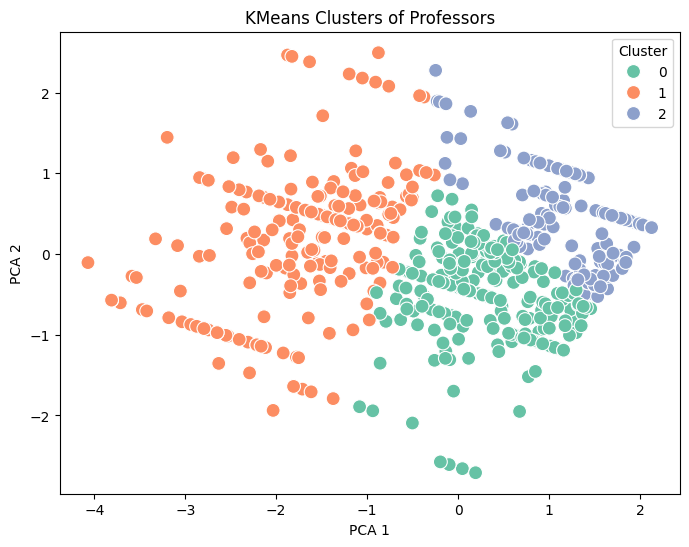

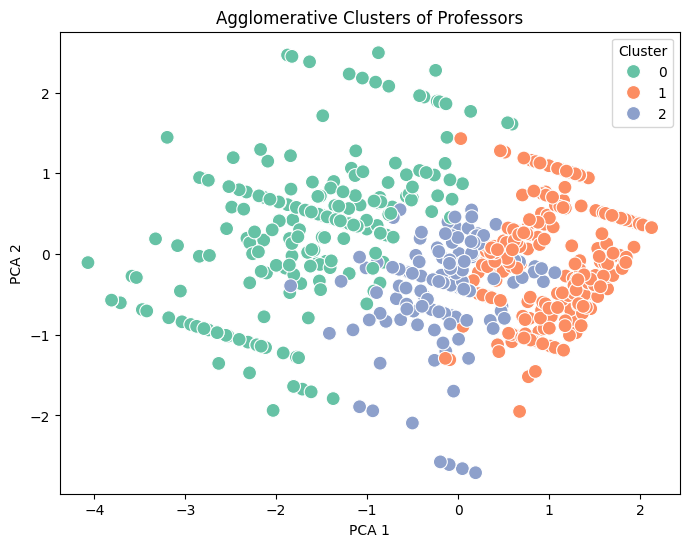

In [20]:
plot_clusters(prof_agg, 'kmeans_cluster', 'KMeans Clusters of Professors')
plot_clusters(prof_agg, 'agglo_cluster', 'Agglomerative Clusters of Professors')

In [21]:
def describe_clusters(df, cluster_col):
    desc = []
    for c in sorted(df[cluster_col].unique()):
        sub = df[df[cluster_col]==c]
        count = len(sub)
        avg_score = sub['overall_score'].mean()
        avg_sent = sub['mean_sentiment'].mean()
        avg_grade = sub['grading_numeric'].mean()
        # simple human interpretation rules
        if avg_score >= 4 and avg_sent >= 0.3:
            desc_str = f"Cluster {c} ({count} professors): Easy / liked by students"
        elif avg_score <= 2.5 and avg_sent <= -0.3:
            desc_str = f"Cluster {c} ({count} professors): Hard / unpopular"
        elif avg_score >= 3.5 and avg_sent <= 0:
            desc_str = f"Cluster {c} ({count} professors): Easy but neutral or mixed satisfaction"
        elif avg_score <= 3 and avg_sent >= 0:
            desc_str = f"Cluster {c} ({count} professors): Hard but liked"
        else:
            desc_str = f"Cluster {c} ({count} professors): Medium difficulty / medium satisfaction"
        desc.append(desc_str)
    return desc




In [22]:
# Print KMeans clusters
print("KMeans cluster descriptions:")
for d in describe_clusters(prof_agg, 'kmeans_cluster'):
    print("-", d)

# Print Agglomerative clusters
print("\nAgglomerative cluster descriptions:")
for d in describe_clusters(prof_agg, 'agglo_cluster'):
    print("-", d)

KMeans cluster descriptions:
- Cluster 0 (260 professors): Medium difficulty / medium satisfaction
- Cluster 1 (206 professors): Easy but neutral or mixed satisfaction
- Cluster 2 (194 professors): Easy / liked by students

Agglomerative cluster descriptions:
- Cluster 0 (211 professors): Easy but neutral or mixed satisfaction
- Cluster 1 (311 professors): Easy / liked by students
- Cluster 2 (138 professors): Medium difficulty / medium satisfaction
